# Parse Data

In [716]:
CUTOFF = 10

In [695]:
PATH_THUIR2 = 'data/THUIR2/search_logs.xml'

try:
    import xml.etree.cElementTree as ET
except ImportError:
    import xml.etree.ElementTree as ET
import json

def xml_to_dict(element):
    node = {}

    text = getattr(element, 'text', None)
    if text is not None:
        text = text.strip()
        # no attributes or children
        if text and not element.attrib and len(element) == 0:  
            return text

    node.update(element.attrib)

    for child in element:
        child_data = xml_to_dict(child)

        if child.tag not in node:
            node[child.tag] = child_data
        else:
            if type(node[child.tag]) is list:
                node[child.tag].append(child_data)
            else:
                node[child.tag] = [node[child.tag], child_data]

    return node

def parse_xml_to_json(xml_file_path, json_file_path):
    # 解析 XML 文件
    myParser = ET.XMLParser(encoding="utf-8")
    tree = ET.parse(xml_file_path, parser=myParser)
    root = tree.getroot()

    # 转换为 JSON
    data_dict = xml_to_dict(root)
    with open(json_file_path, 'w', encoding='utf-8') as json_file:
        json.dump(data_dict, json_file, ensure_ascii=False, indent=4)
    
    return data_dict
    

thuir2_parsed = parse_xml_to_json(PATH_THUIR2, 'data/THUIR2_parsed.json')
thuir2_ss = thuir2_parsed['session']

In [696]:
# sample data
#print(thuir2_ss[0])

# Utility Functions to Get Document Usefulness & Relevance

In [697]:
import csv

PATH_USEFULNESS = 'data/THUIR2/usefulness_annotation.tsv'
PATH_RELEVANCE = 'data/THUIR2/relevance_annotation.tsv'
# This dict will hold the usefulness data
# First key: userid
# Second key: docno
usefulness_data = {}

# Read the CSV file
with open(PATH_USEFULNESS, 'r') as file:
    reader = csv.reader(file, delimiter='\t')
    next(reader)  # Skip the header row
    for row in reader:
        # Get the userid, docno, and usefulness from each row
        userid = row[1]
        docno = row[4]
        usefulness = row[8]

        # Add the data to the dict
        if userid not in usefulness_data:
            usefulness_data[userid] = {}
        usefulness_data[userid][docno] = int(usefulness)

# This dict will hold the relevance data
relevance_data = {}

# Read the CSV file
with open(PATH_RELEVANCE, 'r') as file:
    reader = csv.reader(file, delimiter='\t')
    next(reader)  # Skip the header row
    for row in reader:
        # Get the docno and relevance from each row
        docno = row[2]
        relevance = row[3]

        # Add the data to the dict
        relevance_data[docno] = int(relevance)
        

In [820]:
# Print the usefulness data
# This is actually no use
#print(dict(list(usefulness_data.items())[:5]))

In [819]:
# Print the relevance data
print(dict(list(relevance_data.items())[:5]))

{'199': 1, '18606': 1, '9681': 2, '19787': 2, '20589': 4}


# Utility Functions to Compute Sentence Similarity

In [700]:
from Levenshtein import distance, ratio
import jieba
from collections import Counter
from math import sqrt

SW_PATH = 'utils/stop_words.txt'
SW_LIST = [k.strip() for k in open(SW_PATH, encoding='utf8').readlines() if k.strip() != '']

# Get Stopword List
def get_tl_no_sw(input_sentence):
    token_list = jieba.cut(input_sentence)
    return list(filter(lambda x: not(x == ' ' or (len(x) == 1 and x in SW_LIST)), token_list))


In [701]:
# Solution 1
# Levenshtein normalized similarity

def get_lev_sim(list1, list2):
    return ratio(''.join(sl_no_sw_1), ''.join(sl_no_sw_2))

# Solution 2
# Cosine Similarity

def get_cos_sim(list1, list2):
    # Step 1: Create a vocabulary
    vocab = set(list1) | set(list2)
    
    # Step 2: Create word frequency vectors
    vec1 = Counter(list1)
    vec2 = Counter(list2)
    
    # Step 3: Calculate cosine similarity
    intersection = set(vec1.keys()) & set(vec2.keys())
    numerator = sum([vec1[x] * vec2[x] for x in intersection])

    sum1 = sum([vec1[x]**2 for x in vec1.keys()])
    sum2 = sum([vec2[x]**2 for x in vec2.keys()])
    denominator = sqrt(sum1) * sqrt(sum2)

    if not denominator:
        return 0.0
    else:
        return float(numerator) / denominator


In [702]:
# sample data
sentence1 = '破冰游戏又称融冰游戏，是打破人际交往间怀疑、猜忌，就象打破严冬厚厚的冰层。这个破冰拓展游戏帮助人们变得乐于交往和相互学习，打破陌生人之间的隔膜，消除同事间的积...'
sentence2 = '破冰游戏大全提供各种团队破冰游戏和小组破冰游戏，打破人际交往间怀疑、猜忌、疏远的篱樊，帮助人们放松并变得乐于交往和相互学习。'
sl_no_sw_1 = get_tl_no_sw(sentence1)
sl_no_sw_2 = get_tl_no_sw(sentence2)

print("Lev Sim: %.3f" % get_lev_sim(sl_no_sw_1, sl_no_sw_2))
print("Cos Sim: %.3f" % get_cos_sim(sl_no_sw_1, sl_no_sw_2))


Lev Sim: 0.512
Cos Sim: 0.681


In [703]:
from tqdm import tqdm

# Define a placeholder get_sim function for demonstration purpose
def get_sim(tl_1, tl_2):
    return get_cos_sim(tl_1, tl_2)

In [539]:
# Create a dictionary to hold each document's title, snippet grouped by topic
documents_by_topic = {}

for session in tqdm(thuir2_ss, desc="Processing records"):
    topic = session["topic"]["num"]
    interactions = session["interaction"]
    
    # Helper function to process results and store document info by topic
    def process_results_by_topic(results, topic):
        for doc in results:
            doc_id = doc["id"]
            doc_info = doc["title"] + " " + str(doc["snippet"])
            doc_token_list = get_tl_no_sw(doc_info)
            if topic not in documents_by_topic:
                documents_by_topic[topic] = {}
            documents_by_topic[topic][doc_id] = doc_info

    # Check if interactions is a list or a dict
    if isinstance(interactions, list):
        for interaction in interactions:
            # Check if "results" is not empty
            if interaction.get("results"):
                results = interaction["results"]["result"]
                process_results_by_topic(results, topic)
    elif isinstance(interactions, dict):
        # Check if "results" is not empty
        if interactions.get("results"):
            results = interactions["results"]["result"]
            process_results_by_topic(results, topic)

Processing records: 100%|█████████████████████| 225/225 [00:05<00:00, 41.60it/s]


In [541]:
# VERY time consuming
def get_similarity_pair():
    similarity_scores = {}
    # For each topic, compare each document with every other document in the same topic
    for topic, documents in documents_by_topic.items():
        print("Currently processing: " + topic)
        for doc_id1 in tqdm(documents, desc="Processing topics"):
            for doc_id2 in documents:
                # Ensure doc_id1 is smaller than doc_id2
                if doc_id1 >= doc_id2:
                    continue
                # Calculate similarity
                similarity = get_sim(documents[doc_id1], documents[doc_id2])
                # Store in the dictionary
                if doc_id1 not in similarity_scores:
                    similarity_scores[doc_id1] = {}
                similarity_scores[doc_id1][doc_id2] = similarity

    # Save the similarity scores to a JSON file
    OUTPUT_FILE = "output/similarity_scores.json"
    with open(OUTPUT_FILE, 'w') as f:
        json.dump(similarity_scores, f)


In [900]:
#get_similarity_pair()

# Read json file directly
with open('output/similarity_scores.json', 'r', encoding='utf-8') as file:
    similarity_scores = json.load(file)


In [901]:
similarity_pair_list = [(docno1, docno2, score) 
               for docno1, inner_dict in similarity_scores.items() 
               for docno2, score in inner_dict.items()]

print(similarity_pair_list[:20])

[('1', '2', 0.45961940777125593), ('1', '3', 0.42759637577789017), ('1', '4', 0.51428352870058), ('1', '5', 0.41316712200642336), ('1', '6', 0.5342072242964954), ('1', '7', 0.37119616932281163), ('1', '8', 0.5458670563274626), ('1', '9', 0.2405626121623441), ('1', '10', 0.4283836420813328), ('1', '14182', 0.3447271465312176), ('1', '14183', 0.2590095632952705), ('1', '14184', 0.3118047822311618), ('1', '14185', 0.15523010514126656), ('1', '14186', 0.1666666666666667), ('1', '14187', 0.2403809869102058), ('1', '14188', 0.3889733106610521), ('1', '14189', 0.11612216904860295), ('1', '14190', 0.10067340828210367), ('1', '14191', 0.09723055853282468), ('1', '16145', 0.3286878675669583)]


In [902]:
import numpy as np

# Extract the similarity scores
similarity_list = [x[2] for x in similarity_pair_list]

# Function to calculate the xth percentile
def calculate_percentile(scores, x):
    return np.percentile(scores, x)

# Calculate percentiles for 10, 20, 25, 50, 75, 90
percentiles = [80, 90, 95, 99, 99.5, 99.9]
percentile_values = {x: calculate_percentile(similarity_list, x) for x in percentiles}

percentile_values

{80: 0.3200378765462651,
 90: 0.39717310945384937,
 95: 0.4673017274310339,
 99: 0.6260429022366066,
 99.5: 0.7085457904689538,
 99.9: 0.9999999999999999}

# Find Potential Decoy Pairs

In [903]:
#SIM_HERESHOLD_UNIFY = 0.75

In [1038]:
# 假设的相似度阈值
SIM_THRESHOLD_DECOY_MIN = calculate_percentile(similarity_list, 99) 
SIM_THRESHOLD_DECOY_MAX = 0.95
decoy_pair = []  # 初始化 decoy_pair 字典

# 定义一个函数来处理交互，这样我们可以在交互是列表或字典时重复使用它
def find_decoy_pair(interaction, session_num):
    if 'result' not in interaction['results']:
        #print(interaction['results'])
        return
    # 提取 docno 和 rank
    docnos = [result['id'] for result in interaction['results']['result']]
    ranks = [result['rank'] for result in interaction['results']['result']]
    # 提取点击记录，如果存在的话
    #clicked_items = []
    #if "clicked" in interaction and "click" in interaction["clicked"]:
    #    clicked_items = [item["docno"] for item in interaction["clicked"]["click"] if isinstance(item, dict)]
    
    # 只考虑结果的前K个文档
    for i in range(min(CUTOFF, len(docnos))):
        for j in range(i+1, min(CUTOFF, len(docnos))):
            docno1, rank1 = docnos[i], ranks[i]
            docno2, rank2 = docnos[j], ranks[j]
            if docno1 > docno2:  # 确保 docno1 < docno2
                docno1, docno2 = docno2, docno1
                rank1, rank2 = rank2, rank1
            # 检查条件
            rel_doc1 = relevance_data[docno1] if docno1 in relevance_data else 0
            rel_doc2 = relevance_data[docno2] if docno2 in relevance_data else 0
            
            if similarity_scores[docno1][docno2] >= SIM_THRESHOLD_DECOY_MIN and similarity_scores[docno1][docno2] <= SIM_THRESHOLD_DECOY_MAX:
                if rel_doc1 - rel_doc2 >= 2:
                #if docno1 in clicked_items and docno2 not in clicked_items:
                    decoy_pair.append({'session_num': session_num, 'interaction_num': interaction['num'], 
                                       'docno_target': docno1, 'rank_target': rank1, 
                                       'docno_decoy': docno2, 'rank_decoy': rank2})
                elif rel_doc2 - rel_doc1 >= 2:
                #elif docno2 in clicked_items and docno1 not in clicked_items:
                    decoy_pair.append({'session_num': session_num, 'interaction_num': interaction['num'], 
                                       'docno_target': docno2, 'rank_target': rank2, 
                                       'docno_decoy': docno1, 'rank_decoy': rank1})


# 遍历每条记录
for record in tqdm(thuir2_ss, desc="Processing sessions", unit="session"):
    session_num = record['num']  # 提取 session num
    # 遍历每次交互
    interactions = record['interaction']
    if isinstance(interactions, list):  # 如果交互是一个列表
        for interaction in interactions:
            find_decoy_pair(interaction, session_num)
    elif isinstance(interactions, dict):  # 如果交互是一个字典
        find_decoy_pair(interactions, session_num)
        
        
print(len(decoy_pair))
print(decoy_pair[:10])

Processing sessions: 100%|█████████████| 225/225 [00:00<00:00, 5465.92session/s]

1535
[{'session_num': '1', 'interaction_num': '1', 'docno_target': '2', 'rank_target': '1', 'docno_decoy': '6', 'rank_decoy': '5'}, {'session_num': '1', 'interaction_num': '1', 'docno_target': '2', 'rank_target': '1', 'docno_decoy': '10', 'rank_decoy': '9'}, {'session_num': '1', 'interaction_num': '1', 'docno_target': '3', 'rank_target': '2', 'docno_decoy': '6', 'rank_decoy': '5'}, {'session_num': '1', 'interaction_num': '1', 'docno_target': '4', 'rank_target': '3', 'docno_decoy': '6', 'rank_decoy': '5'}, {'session_num': '1', 'interaction_num': '1', 'docno_target': '8', 'rank_target': '7', 'docno_decoy': '6', 'rank_decoy': '5'}, {'session_num': '1', 'interaction_num': '3', 'docno_target': '16145', 'rank_target': '0', 'docno_decoy': '16146', 'rank_decoy': '1'}, {'session_num': '1', 'interaction_num': '3', 'docno_target': '16148', 'rank_target': '3', 'docno_decoy': '16146', 'rank_decoy': '1'}, {'session_num': '3', 'interaction_num': '1', 'docno_target': '1630', 'rank_target': '1', 'docno

In [1039]:
decoy_index = [item['docno_target'] for item in decoy_pair]
print("Decoy Pairs Count: %d"%len(decoy_index))
print("Count of Documents that have at least one decoy: %d"%len(set(decoy_index)))
#print(decoy_index[:5])

Decoy Pairs Count: 1535
Count of Documents that have at least one decoy: 459


# Find Control Documents

In [1040]:
# Assuming a threshold for the sake of demonstration
SIM_THRESHOLD_CONTROL = calculate_percentile(similarity_list, 99.5)  
print(SIM_THRESHOLD_CONTROL)
target_doc_list = []
control_doc_list = []

# Processing the data as per given conditions
for docno1, docno2, similarity_score in similarity_pair_list:
    if similarity_score > SIM_THRESHOLD_CONTROL:
        # 检查条件
        rel_doc1 = relevance_data[docno1] if docno1 in relevance_data else 0
        rel_doc2 = relevance_data[docno2] if docno2 in relevance_data else 0
        if abs(rel_doc1 - rel_doc2 <= 2):
            if (docno1 in decoy_index and docno2 not in decoy_index):
                target_doc_list.append(docno1)
                control_doc_list.append(docno2)
            elif (docno2 in decoy_index and docno1 not in decoy_index):
                target_doc_list.append(docno2)
                control_doc_list.append(docno1)

target_doc_set = set(target_doc_list)
print("Count of Target Documents that have at least one Control Document: %d"% len(target_doc_set))
control_doc_set = set(control_doc_list)
print("Count of Control Documents: %d" % len(control_doc_set))

0.7085457904689538
Count of Target Documents that have at least one Control Document: 373
Count of Control Documents: 968


In [1041]:
decoy_target_record = []
decoy_decoy_record = []
for item in decoy_pair:
    if item['docno_target'] in target_doc_set:
        target_id = item['session_num'] + '_' + item['interaction_num'] + '_' + item['docno_target']
        decoy_id =  item['session_num'] + '_' + item['interaction_num'] + '_' + item['docno_decoy']
        decoy_target_record.append(target_id)
        decoy_decoy_record.append(decoy_id)
    
decoy_target_record = set(decoy_target_record)
decoy_decoy_record = set(decoy_decoy_record)

print("Records of decoy target documents, by impression : %d"%len(decoy_target_record))
#print(len(decoy_decoy_record))

Records of decoy target documents, by impression : 1000


# Compare User Feedback

In [1042]:
def process_user_feedback(results, decoy_target_record, session_num, interaction_num):
    """
    Process the results to extract required information.
    """
    interactions_list = []
    
    for item in results:
        record_id = session_num + '_' + interaction_num + '_' + item['id']
        # Check if record_id is in decoy_target_record
        # And whether the document has at least one control document
        if record_id in decoy_target_record and int(item['rank']) < CUTOFF:
            if "clicked" in interaction and "click" in interaction["clicked"]:
                clicked_items = interaction["clicked"]["click"]
                clicked = False
                endtime = -1
                starttime = -1
                usefulness = 0
                for click_item in clicked_items:
                    if isinstance(click_item, dict) and item['id'] == click_item["docno"]:
                        clicked = True
                        endtime = float(click_item['endtime'])
                        starttime = float(click_item['starttime'])
                        usefulness = float(click_item["annotation"]['score'])
                        break
            else:
                clicked = False
                endtime = -1
                starttime = -1
                usefulness = 0

            if clicked:
                interactions_list.append({'docno': item['id'], 'rank':  int(item["rank"]), 'click': True, 'endtime': endtime, 'starttime': starttime, 'usefulness': usefulness})
            else:
                interactions_list.append({'docno': item['id'], 'rank':   int(item["rank"]), 'click': False, 'endtime': -1, 'starttime': -1, 'usefulness': 0})
                
    return interactions_list


target_doc_interaction = []

for session in thuir2_ss:
    session_num = session["num"]
    interactions = session["interaction"]
    
    # Check if interactions is a list or a dict
    if isinstance(interactions, list):
        for interaction in interactions:
            interaction_num = interaction["num"]
            if interaction.get("results"):
                results = interaction["results"]["result"]
                interactions_list = process_user_feedback(results, decoy_target_record, session_num, interaction_num)
                target_doc_interaction.extend(interactions_list)
    
    elif isinstance(interactions, dict):
        interaction_num = interactions["num"]
        if interaction.get("results"):
            results = interactions["results"]["result"]
            interactions_list = process_user_feedback(results, decoy_target_record, session_num, interaction_num)
            target_doc_interaction.extend(interactions_list)

print(len(target_doc_interaction))

987


In [1043]:
def process_control_docs(results, control_doc_set):
    """
    Process the results to extract required information for control docs.
    """
    interactions_list = []
    
    for item in results:
        # Check if the item's id is in control_doc_set
        if item['id'] in control_doc_set and int(item['rank']) < CUTOFF:
            if "clicked" in interaction and "click" in interaction["clicked"]:
                clicked_items = interaction["clicked"]["click"]
                clicked = False
                endtime = -1
                starttime = -1
                usefulness = 0
                for click_item in clicked_items:
                    if isinstance(click_item, dict) and item['id'] == click_item["docno"]:
                        clicked = True
                        endtime = float(click_item['endtime'])
                        starttime = float(click_item['starttime'])
                        usefulness = float(click_item["annotation"]['score'])
                        break
            else:
                clicked = False
                endtime = -1
                starttime = -1
                usefulness = 0

            if clicked:
                interactions_list.append({'docno': item['id'], 'rank':  int(item["rank"]), 'click': True, 'endtime': endtime, 'starttime': starttime, 'usefulness': usefulness})
            else:
                interactions_list.append({'docno': item['id'], 'rank':  int(item["rank"]), 'click': False, 'endtime': -1, 'starttime': -1, 'usefulness': 0})
                
    return interactions_list

# Initialize the list for control doc interactions
control_doc_interaction = []

for session in thuir2_ss:
    interactions = session["interaction"]
    
    # Check if interactions is a list or a dict
    if isinstance(interactions, list):
        for interaction in interactions:
            if interaction.get("results"):
                results = interaction["results"]["result"]
                interactions_list = process_control_docs(results, control_doc_set)
                control_doc_interaction.extend(interactions_list)
    
    elif isinstance(interactions, dict):
        if interaction.get("results"):
            results = interactions["results"]["result"]
            interactions_list = process_control_docs(results, control_doc_set)
            control_doc_interaction.extend(interactions_list)
        
print(len(control_doc_interaction))

1508


In [1044]:
target_doc_interaction[:3]

[{'docno': '2',
  'rank': 1,
  'click': False,
  'endtime': -1,
  'starttime': -1,
  'usefulness': 0},
 {'docno': '3',
  'rank': 2,
  'click': False,
  'endtime': -1,
  'starttime': -1,
  'usefulness': 0},
 {'docno': '4',
  'rank': 3,
  'click': False,
  'endtime': -1,
  'starttime': -1,
  'usefulness': 0}]

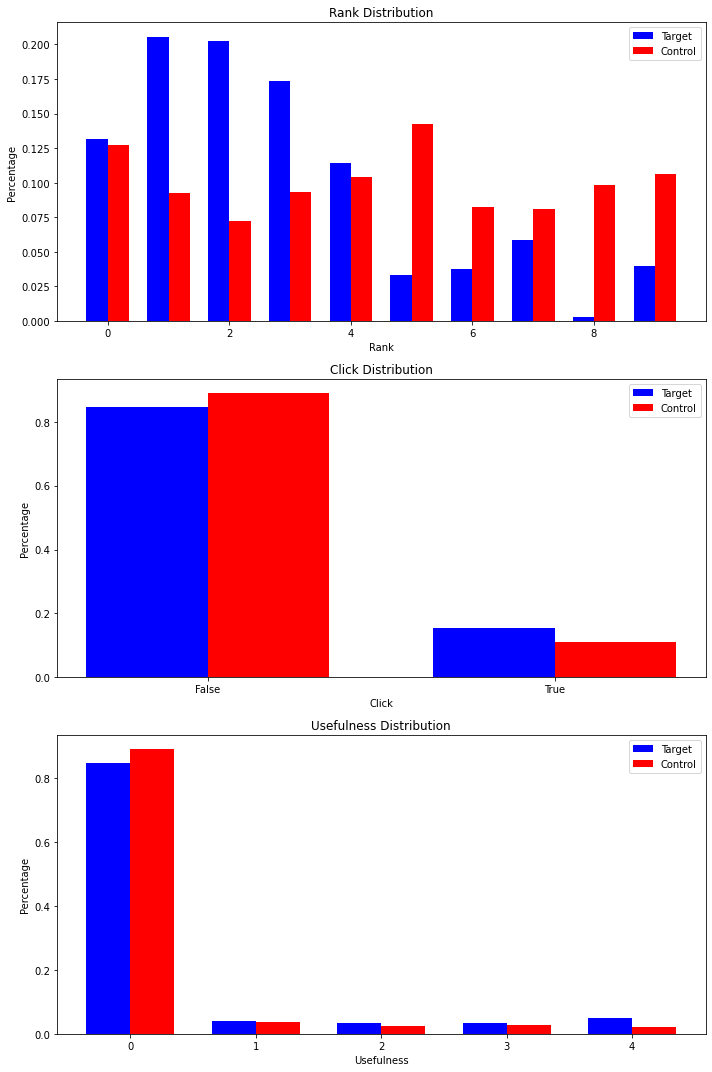

In [1045]:
import matplotlib.pyplot as plt

# Extract rank, click, and usefulness values
def extract_values(data):
    ranks = [item['rank'] for item in data]
    clicks = [item['click'] for item in data]
    usefulness = [item['usefulness'] for item in data]
    return ranks, clicks, usefulness

# Adjust the percentage calculation to account for ordering
def calculate_percentage_ordered(values, unique_values):
    total_len = len(values)
    return [values.count(val) / total_len for val in unique_values]

target_ranks, target_clicks, target_usefulness = extract_values(target_doc_interaction)
control_ranks, control_clicks, control_usefulness = extract_values(control_doc_interaction)

# Get unique values for ordering
ranks = list(set(target_ranks + control_ranks))
click_labels = ['False', 'True']
usefulness_values = list(set(target_usefulness + control_usefulness))

# Calculate ordered percentages
target_ranks_percentage = calculate_percentage_ordered(target_ranks, ranks)
control_ranks_percentage = calculate_percentage_ordered(control_ranks, ranks)

target_clicks_percentage = calculate_percentage_ordered(target_clicks, [False, True])
control_clicks_percentage = calculate_percentage_ordered(control_clicks, [False, True])

target_usefulness_percentage = calculate_percentage_ordered(target_usefulness, usefulness_values)
control_usefulness_percentage = calculate_percentage_ordered(control_usefulness, usefulness_values)

# Plot with y-axis as percentage
fig, axs = plt.subplots(3, 1, figsize=(10, 15))
width = 0.35

# Rank distribution
axs[0].bar([rank - width/2 for rank in ranks], target_ranks_percentage, width, label='Target', color='blue')
axs[0].bar([rank + width/2 for rank in ranks], control_ranks_percentage, width, label='Control', color='red')
axs[0].set_title('Rank Distribution')
axs[0].set_xlabel('Rank')
axs[0].set_ylabel('Percentage')
axs[0].legend()

# Click distribution
axs[1].bar([x - width/2 for x in range(len(click_labels))], target_clicks_percentage, width, label='Target', color='blue')
axs[1].bar([x + width/2 for x in range(len(click_labels))], control_clicks_percentage, width, label='Control', color='red')
axs[1].set_title('Click Distribution')
axs[1].set_xticks(range(len(click_labels)))
axs[1].set_xticklabels(click_labels)
axs[1].set_xlabel('Click')
axs[1].set_ylabel('Percentage')
axs[1].legend()

# Usefulness distribution
axs[2].bar([val - width/2 for val in usefulness_values], target_usefulness_percentage, width, label='Target', color='blue')
axs[2].bar([val + width/2 for val in usefulness_values], control_usefulness_percentage, width, label='Control', color='red')
axs[2].set_title('Usefulness Distribution')
axs[2].set_xlabel('Usefulness')
axs[2].set_ylabel('Percentage')
axs[2].legend()

plt.tight_layout()
plt.show()

In [1046]:
from scipy import stats


# Calculate metrics for a given interaction list
def calculate_metrics(interaction_list):
    click_probs = [1 if interaction['click'] else 0 for interaction in interaction_list]
    avg_click_prob = sum(click_probs) / len(interaction_list)

    browsing_times = [interaction['endtime'] - interaction['starttime'] if interaction['click'] else 0 for interaction in interaction_list]
    avg_browsing_time = sum(browsing_times) / len(interaction_list)

    usefulness_scores = [interaction['usefulness'] for interaction in interaction_list]
    avg_usefulness = sum(usefulness_scores) / len(interaction_list)
    
    ranks = [entry['rank'] for entry in interaction_list]
    avg_rank = np.mean(ranks)
    
    return avg_click_prob, avg_browsing_time, avg_usefulness, avg_rank

# Calculate the metrics for both interaction lists
target_avg_click_prob, target_avg_browsing_time, target_avg_usefulness, target_avg_rank = calculate_metrics(target_doc_interaction)
control_avg_click_prob, control_avg_browsing_time, control_avg_usefulness, control_avg_rank = calculate_metrics(control_doc_interaction)

# Conduct t-tests to compare the means
click_prob_t_stat, click_prob_p_val = stats.ttest_ind([interaction['click'] for interaction in target_doc_interaction],
                                                     [interaction['click'] for interaction in control_doc_interaction])

browsing_time_t_stat, browsing_time_p_val = stats.ttest_ind(
    [interaction['endtime'] - interaction['starttime'] if interaction['click'] else 0 for interaction in target_doc_interaction],
    [interaction['endtime'] - interaction['starttime'] if interaction['click'] else 0 for interaction in control_doc_interaction]
)

usefulness_t_stat, usefulness_p_val = stats.ttest_ind([interaction['usefulness'] for interaction in target_doc_interaction],
                                                     [interaction['usefulness'] for interaction in control_doc_interaction])


rank_t_stat, rank_p_val = stats.ttest_ind([interaction['rank'] for interaction in target_doc_interaction],
                                                     [interaction['rank'] for interaction in control_doc_interaction])

{
    "target_metrics": {
        "avg_click_prob": target_avg_click_prob,
        "avg_browsing_time": target_avg_browsing_time,
        "avg_usefulness": target_avg_usefulness,
        "avg_rank": target_avg_rank,
    },
    "control_metrics": {
        "avg_click_prob": control_avg_click_prob,
        "avg_browsing_time": control_avg_browsing_time,
        "avg_usefulness": control_avg_usefulness,
        "avg_rank": control_avg_rank,
    },
    "t_test_results": {
        "click_prob": {"t_stat": click_prob_t_stat, "p_val": click_prob_p_val},
        "browsing_time": {"t_stat": browsing_time_t_stat, "p_val": browsing_time_p_val},
        "usefulness": {"t_stat": usefulness_t_stat, "p_val": usefulness_p_val},
        "rank": {"t_stat": rank_t_stat, "p_val": rank_p_val},
    }
}

{'target_metrics': {'avg_click_prob': 0.1540020263424519,
  'avg_browsing_time': 6.379857142857142,
  'avg_usefulness': 0.39918946301925023,
  'avg_rank': 2.7720364741641337},
 'control_metrics': {'avg_click_prob': 0.11007957559681697,
  'avg_browsing_time': 3.4430935013262616,
  'avg_usefulness': 0.2493368700265252,
  'avg_rank': 4.446949602122016},
 't_test_results': {'click_prob': {'t_stat': 3.222305468494078,
   'p_val': 0.001288022569712457},
  'browsing_time': {'t_stat': 2.9186483528622875,
   'p_val': 0.0035470123050321506},
  'usefulness': {'t_stat': 4.043137566815833, 'p_val': 5.434043827840075e-05},
  'rank': {'t_stat': -15.266702813893916, 'p_val': 2.2527967092934344e-50}}}

In [1049]:
# Split the interactions into three groups based on rank
def split_by_rank(interactions):
    group1 = [item for item in interactions if 0 <= item['rank'] <= 4]
    group2 = [item for item in interactions if 5 <= item['rank'] <= 9]
    group3 = [item for item in interactions if 9 <= item['rank'] <= 9]
    group4 = [item for item in interactions if 9 <= item['rank'] <= 9]
    group5 = [item for item in interactions if item['rank'] >= 9]
    return group1, group2, group3, group4, group5

# Split target and control interactions by rank
target_groups = split_by_rank(target_doc_interaction)
control_groups = split_by_rank(control_doc_interaction)

# Calculate metrics for each group and perform t-tests
results = []

for i in range(5):
    target_metrics = calculate_metrics(target_groups[i])
    control_metrics = calculate_metrics(control_groups[i])

    click_prob_ttest = ttest_ind([entry['click'] for entry in target_groups[i]], [entry['click'] for entry in control_groups[i]])
    rank_ttest = ttest_ind([entry['rank'] for entry in target_groups[i]], [entry['rank'] for entry in control_groups[i]])
    view_time_ttest = ttest_ind([entry['endtime'] - entry['starttime'] if entry['click'] else 0 for entry in target_groups[i]], 
                                [entry['endtime'] - entry['starttime'] if entry['click'] else 0 for entry in control_groups[i]])
    usefulness_ttest = ttest_ind([entry['usefulness'] for entry in target_groups[i]], [entry['usefulness'] for entry in control_groups[i]])

    results.append({
        'group': i+1,
        'target_metrics': target_metrics,
        'control_metrics': control_metrics,
        'click_prob_ttest': click_prob_ttest,
        'view_time_ttest': view_time_ttest,
        'usefulness_ttest': usefulness_ttest,
        'rank_ttest': rank_ttest,
    })

results

[{'group': 1,
  'target_metrics': (0.13708690330477355,
   4.9168384332925354,
   0.3292533659730722,
   1.9192166462668299),
  'control_metrics': (0.16508795669824086,
   5.240001353179974,
   0.37889039242219213,
   1.9066305818673883),
  'click_prob_ttest': Ttest_indResult(statistic=-1.5432703643214574, pvalue=0.12296879179316386),
  'view_time_ttest': Ttest_indResult(statistic=-0.24533597350721467, pvalue=0.8062286940592597),
  'usefulness_ttest': Ttest_indResult(statistic=-1.0344548899753965, pvalue=0.30108450515544916),
  'rank_ttest': Ttest_indResult(statistic=0.17810341463747134, pvalue=0.8586649738636337)},
 {'group': 2,
  'target_metrics': (0.23529411764705882,
   13.410952941176477,
   0.7352941176470589,
   6.870588235294117),
  'control_metrics': (0.05721716514954486,
   1.7162860858257478,
   0.12483745123537061,
   6.888166449934981),
  'click_prob_ttest': Ttest_indResult(statistic=7.576227979862494, pvalue=8.527213464915415e-14),
  'view_time_ttest': Ttest_indResult(sta

In [1048]:
# Impression Level

# Effect of Decoy (distance?)

# Feature 